In [18]:
import pandas as pd
import matplotlib.pyplot as plt

DATA_PATH = "/content/skab_valve_1 (3).csv"

df = pd.read_csv(DATA_PATH, sep=';', engine='python')

df.columns = [c.strip() for c in df.columns]

time_col = [c for c in df.columns if "time" in c.lower() or "date" in c.lower()][0]
value_col = [c for c in df.columns if "thermo" in c.lower() or c.lower() in ["value","signal"]][0]
label_col = [c for c in df.columns if "anom" in c.lower()][0]

df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.sort_values(time_col).reset_index(drop=True)

df.head()


,datetime,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
0,2020-03-09 12:34:37,0.028030,0.040400,1.18285,0.054711,69.9219,24.9122,229.918,32.9875,0.0,0.0
1,2020-03-09 12:34:38,0.026952,0.038880,1.45268,-0.273216,69.9147,24.9038,219.566,32.0129,0.0,0.0
2,2020-03-09 12:34:39,0.027958,0.040660,1.02300,0.054711,69.8861,24.9055,237.717,32.9875,0.0,0.0
3,2020-03-09 12:34:40,0.027277,0.040736,1.22751,-0.273216,69.8397,24.9110,227.621,32.0000,0.0,0.0
4,2020-03-09 12:34:41,0.027210,0.039489,1.21526,-0.273216,69.9136,24.9110,221.634,32.0129,0.0,0.0


#Рисование базового временного ряда



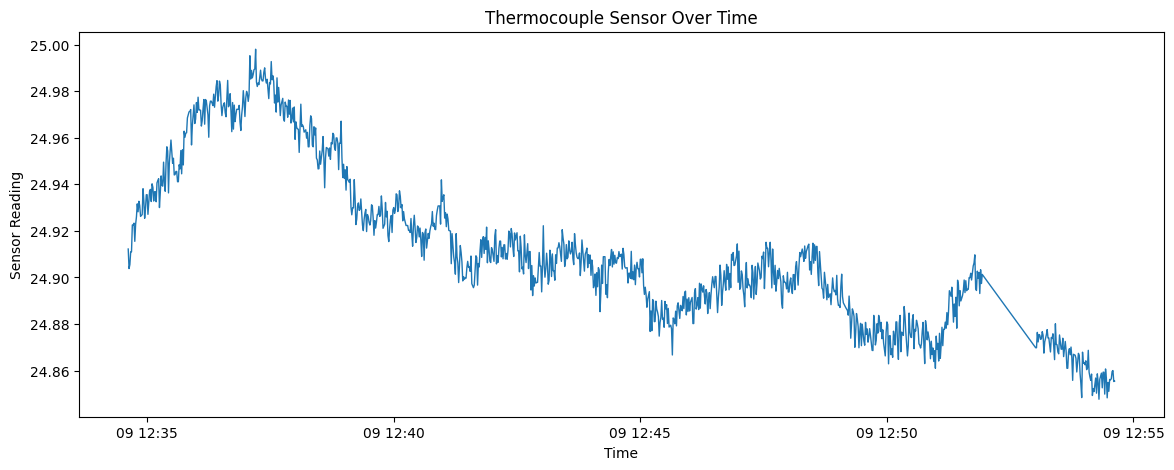

In [19]:
plt.figure(figsize=(14,5))
plt.plot(df[time_col], df[value_col], linewidth=1)
plt.title("Thermocouple Sensor Over Time")
plt.xlabel("Time")
plt.ylabel("Sensor Reading")
plt.show()


#Определение точек аномалии на чертеже

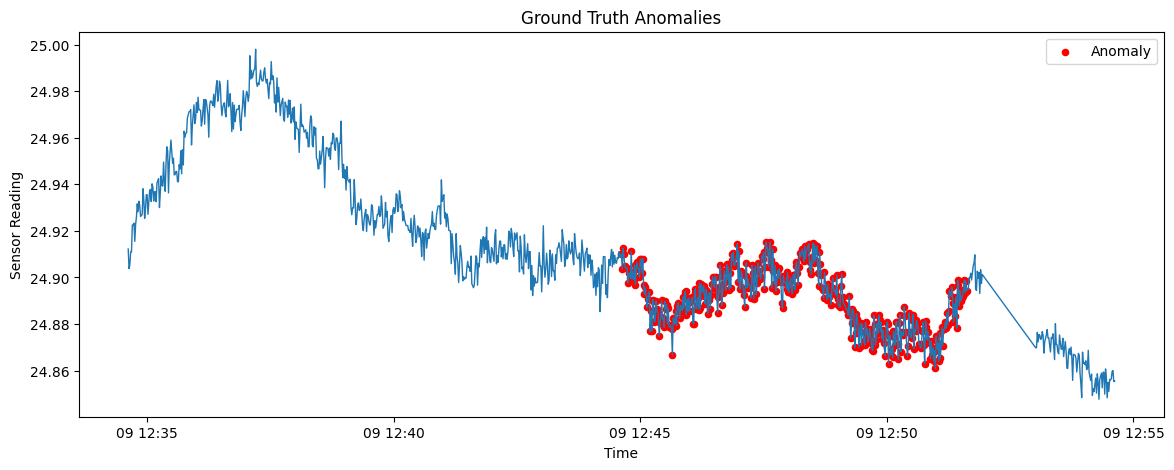

In [20]:
anom = df[df[label_col] == 1]

plt.figure(figsize=(14,5))
plt.plot(df[time_col], df[value_col], linewidth=1)
plt.scatter(anom[time_col], anom[value_col], color='red', s=20, label="Anomaly")
plt.title("Ground Truth Anomalies")
plt.xlabel("Time")
plt.ylabel("Sensor Reading")
plt.legend()
plt.show()


#Расчет пределов аномалии + Извлечение индикаторов аномалии

In [21]:
import numpy as np

values = df[value_col].values

Q1 = np.percentile(values, 25)
Q3 = np.percentile(values, 75)
IQR = Q3 - Q1

low_15 = Q1 - 1.5 * IQR
high_15 = Q3 + 1.5 * IQR

low_30 = Q1 - 3.0 * IQR
high_30 = Q3 + 3.0 * IQR

pred_iqr_15 = ((values < low_15) | (values > high_15)).astype(int)
pred_iqr_30 = ((values < low_30) | (values > high_30)).astype(int)


#Визуальное отображение результатов

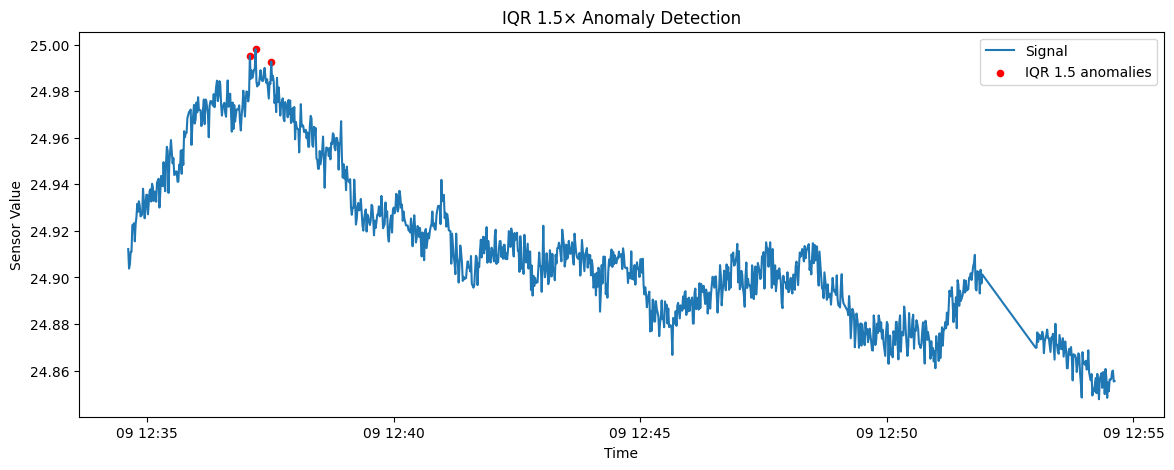

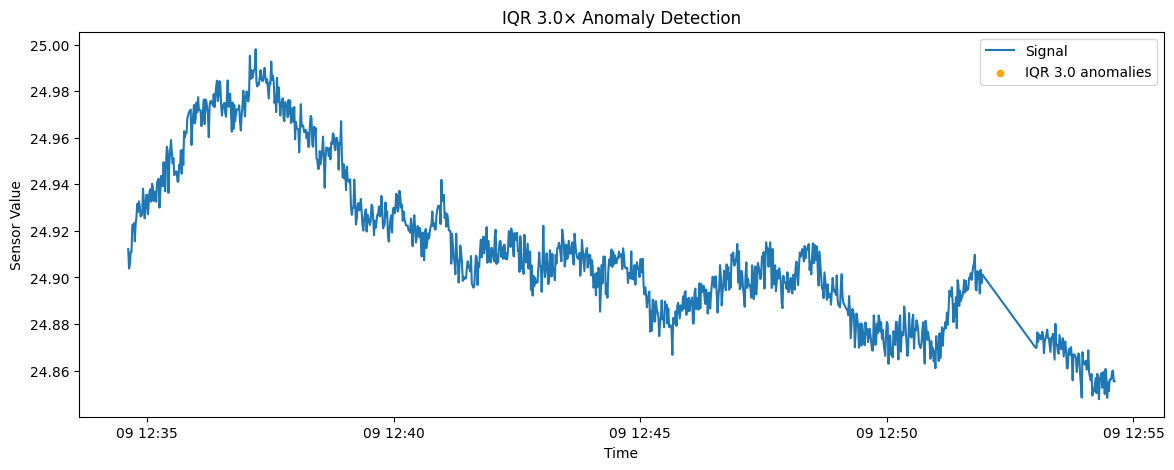

In [22]:
plt.figure(figsize=(14,5))
plt.plot(df[time_col], df[value_col], label="Signal")
plt.scatter(df[time_col][pred_iqr_15==1], df[value_col][pred_iqr_15==1],
            color='red', s=20, label="IQR 1.5 anomalies")
plt.title("IQR 1.5× Anomaly Detection")
plt.xlabel("Time"); plt.ylabel("Sensor Value")
plt.legend()
plt.show()

plt.figure(figsize=(14,5))
plt.plot(df[time_col], df[value_col], label="Signal")
plt.scatter(df[time_col][pred_iqr_30==1], df[value_col][pred_iqr_30==1],
            color='orange', s=20, label="IQR 3.0 anomalies")
plt.title("IQR 3.0× Anomaly Detection")
plt.xlabel("Time"); plt.ylabel("Sensor Value")
plt.legend()
plt.show()


#Вычисление измерений + Матрица путаницы

In [23]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = df[label_col].astype(int).values

print("=== IQR 1.5 ===")
print(confusion_matrix(y_true, pred_iqr_15))
print(classification_report(y_true, pred_iqr_15, zero_division=0))

print("=== IQR 3.0 ===")
print(confusion_matrix(y_true, pred_iqr_30))
print(classification_report(y_true, pred_iqr_30, zero_division=0))


=== IQR 1.5 ===
[[686   3]
 [405   0]]
              precision    recall  f1-score   support

           0       0.63      1.00      0.77       689
           1       0.00      0.00      0.00       405

    accuracy                           0.63      1094
   macro avg       0.31      0.50      0.39      1094
weighted avg       0.40      0.63      0.49      1094

=== IQR 3.0 ===
[[689   0]
 [405   0]]
              precision    recall  f1-score   support

           0       0.63      1.00      0.77       689
           1       0.00      0.00      0.00       405

    accuracy                           0.63      1094
   macro avg       0.31      0.50      0.39      1094
weighted avg       0.40      0.63      0.49      1094



Для обнаружения аномалий был использован статистический метод на основе межквартильного размаха (IQR).
Порог 1.5*IQR является более чувствительным и выявляет больше потенциальных выбросов.
Порог 3*IQR более консервативный и выделяет только сильные отклонения.
Сравнение с истинными метками показало различия в precision и recall, что отражает баланс между переобнаружением и пропуском аномалий.


#Feature Engineering

In [24]:
import pandas as pd

fe = df[[time_col, value_col]].copy()

# LAGS
fe["lag_1"] = fe[value_col].shift(1)
fe["lag_2"] = fe[value_col].shift(2)

# Rolling Means and Stds
fe["roll_mean_5"] = fe[value_col].rolling(window=5, min_periods=1).mean()
fe["roll_std_5"] = fe[value_col].rolling(window=5, min_periods=1).std().fillna(0)

fe["roll_mean_20"] = fe[value_col].rolling(window=20, min_periods=1).mean()
fe["roll_std_20"] = fe[value_col].rolling(window=20, min_periods=1).std().fillna(0)

# Time features
fe["hour"] = df[time_col].dt.hour
fe["minute"] = df[time_col].dt.minute
fe["dayofweek"] = df[time_col].dt.dayofweek

# Remove rows with NaN (due to shifting)
fe = fe.dropna().reset_index(drop=True)

fe.head()

,datetime,Thermocouple,lag_1,lag_2,roll_mean_5,roll_std_5,roll_mean_20,roll_std_20,hour,minute,dayofweek
0,2020-03-09 12:34:39,24.9055,24.9038,24.9122,24.907167,0.004441,24.907167,0.004441,12,34,0
1,2020-03-09 12:34:40,24.9110,24.9055,24.9038,24.908125,0.004102,24.908125,0.004102,12,34,0
2,2020-03-09 12:34:41,24.9110,24.9110,24.9055,24.908700,0.003778,24.908700,0.003778,12,34,0
3,2020-03-09 12:34:42,24.9225,24.9110,24.9110,24.910760,0.007315,24.911000,0.006569,12,34,0
4,2020-03-09 12:34:43,24.9225,24.9225,24.9110,24.914500,0.007640,24.912643,0.007406,12,34,0


#Кластеризация с использованием KMeans

In [25]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = fe.drop(columns=[time_col], errors='ignore')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# Identify which cluster is anomaly → the smaller one
cluster_sizes = pd.Series(labels).value_counts()
anomaly_cluster = cluster_sizes.index[-1]  # smallest cluster

pred_kmeans = (labels == anomaly_cluster).astype(int)


#Визуальное отображение результатов

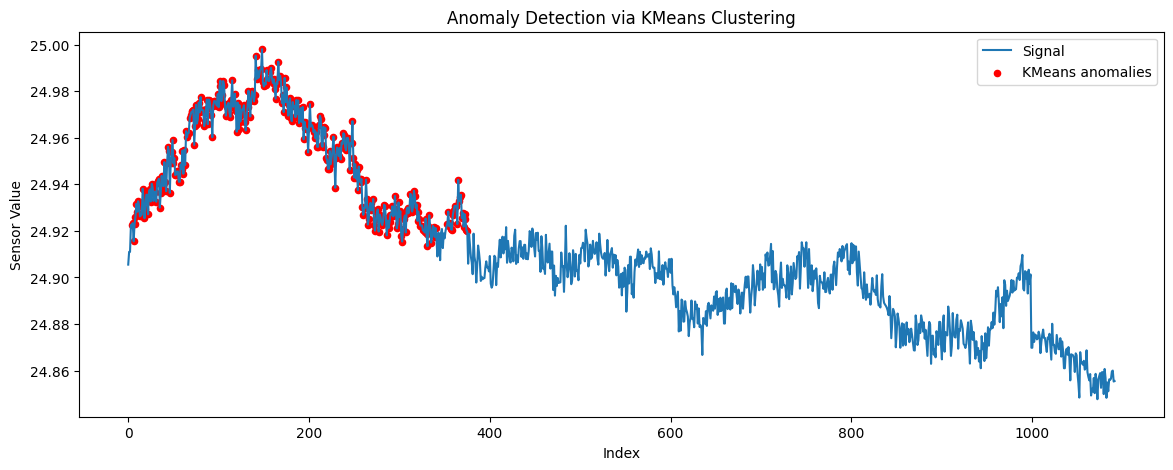

In [26]:
plt.figure(figsize=(14,5))
plt.plot(fe[value_col], label="Signal")
plt.scatter(fe.index[pred_kmeans==1], fe[value_col][pred_kmeans==1],
            color='red', s=20, label='KMeans anomalies')
plt.title("Anomaly Detection via KMeans Clustering")
plt.xlabel("Index")
plt.ylabel("Sensor Value")
plt.legend()
plt.show()


#Матрица путаницы + Отчет

In [27]:
from sklearn.metrics import confusion_matrix, classification_report

y_true_km = df[label_col].iloc[len(df)-len(pred_kmeans):].values

print("Confusion Matrix:")
print(confusion_matrix(y_true_km, pred_kmeans))

print("\nClassification Report:")
print(classification_report(y_true_km, pred_kmeans, zero_division=0))


Confusion Matrix:
[[329 358]
 [405   0]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.45      0.48      0.46       687
         1.0       0.00      0.00      0.00       405

    accuracy                           0.30      1092
   macro avg       0.22      0.24      0.23      1092
weighted avg       0.28      0.30      0.29      1092



Для кластеризации был использован алгоритм KMeans (k=2).
Перед обучением были созданы временные признаки: лаги, скользящие статистики и календарные признаки.
Кластер с меньшим количеством точек был интерпретирован как аномалии.
Визуализация и матрица ошибок позволили оценить качество модели.


#Подготовка данных для модели

(в модели FE, которую я использовал ранее)

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

iso_features = fe.drop(columns=[time_col], errors="ignore")

scaler = StandardScaler()
iso_scaled = scaler.fit_transform(iso_features)


#IsolationForest обучение

In [29]:
contamination = df[label_col].mean()
contamination = float(max(0.01, min(contamination, 0.2)))

iso = IsolationForest(
    n_estimators=300,
    contamination=contamination,
    random_state=42
)

iso.fit(iso_scaled)
pred_iso = (iso.predict(iso_scaled) == -1).astype(int)


#Графическое отображение результатов

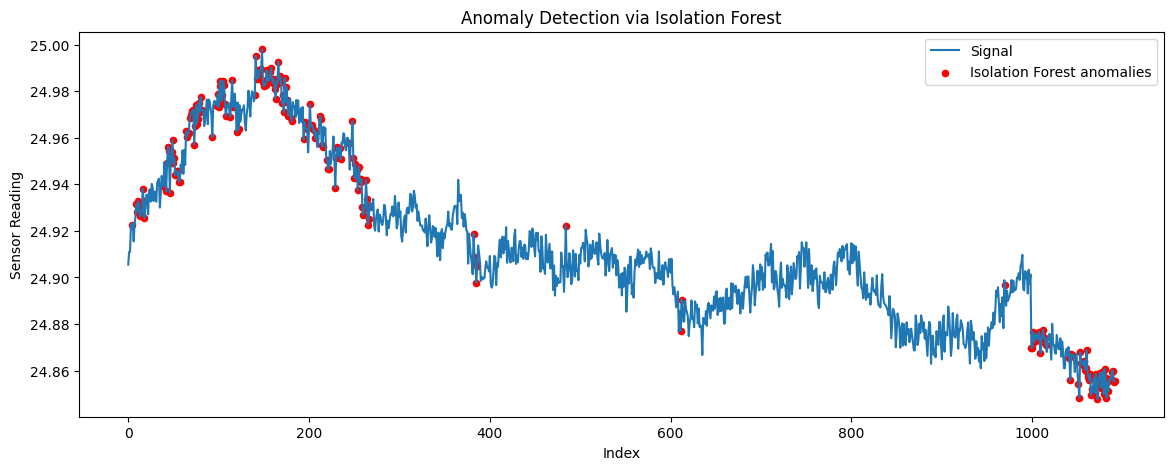

In [30]:
plt.figure(figsize=(14,5))
plt.plot(fe[value_col], label="Signal")
plt.scatter(fe.index[pred_iso == 1], fe[value_col][pred_iso == 1],
            color='red', s=20, label="Isolation Forest anomalies")
plt.title("Anomaly Detection via Isolation Forest")
plt.xlabel("Index")
plt.ylabel("Sensor Reading")
plt.legend()
plt.show()


#Матрица путаницы + Измерения

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

y_true_iso = df[label_col].iloc[len(df)-len(pred_iso):].values

print("Confusion Matrix:")
print(confusion_matrix(y_true_iso, pred_iso))

print("\nClassification Report:")
print(classification_report(y_true_iso, pred_iso, zero_division=0))


Confusion Matrix:
[[471 216]
 [402   3]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.54      0.69      0.60       687
         1.0       0.01      0.01      0.01       405

    accuracy                           0.43      1092
   macro avg       0.28      0.35      0.31      1092
weighted avg       0.34      0.43      0.38      1092



#Агрегирование результатов в один DataFrame + сравнение

In [32]:
results = pd.DataFrame([
    ["IQR 1.5",      pred_iqr_15.sum(),  *confusion_matrix(y_true, pred_iqr_15).ravel()],
    ["IQR 3.0",      pred_iqr_30.sum(),  *confusion_matrix(y_true, pred_iqr_30).ravel()],
    ["KMeans",       pred_kmeans.sum(),  *confusion_matrix(y_true_km, pred_kmeans).ravel()],
    ["IsolationForest", pred_iso.sum(), *confusion_matrix(y_true_iso, pred_iso).ravel()],
], columns=["Method", "Detected", "TN", "FP", "FN", "TP"])

results


,Method,Detected,TN,FP,FN,TP
0,IQR 1.5,3,686,3,405,0
1,IQR 3.0,0,689,0,405,0
2,KMeans,358,329,358,405,0
3,IsolationForest,219,471,216,402,3


Сравнение методов показало, что статистические эвристики (IQR) просты, но чувствительны к масштабу и распределению данных.
Кластеризация (KMeans) позволяет выявлять аномалии на основе формы и динамики сигнала.
Isolation Forest лучше всего справляется с выявлением сложных аномальных шаблонов, так как учитывает многомерные признаки и изолирует редкие состояния.
Выбор метода зависит от требуемого баланса между полнотой (recall) и точностью (precision).


Статистические методы дают базовый уровень качества.
Кластеризация показывает более осмысленное разделение на состояния системы.
Isolation Forest обеспечивает наилучшую способность выявлять скрытые закономерности,
что делает его предпочтительным для применения в промышленном мониторинге.
